In [ ]:
!pip install kaggle
!pip install zipfile36

Defaulting to user installation because normal site-packages is not writeable


### Data preparation and feature engineering

1. Download Titanic dataset from kaggle competition
1. Load dataframe and analyze with `isNa()`, `describe()`, `info()`
1. isNa analysis: replacing Nas with `mode()` -> data interpolation
1. Long-tailed `Fare` attribute analysis with `hist()` -> `logp1` to reduce distribution
1. Categorical attributes (e.g. boarded in) are exploded to binary variables using `get_dummies()`
1. Project only resulting columns, force as float, and normalize by dividing with max value per column

Results is a pytorch rank-2 tensor representing the input data.

In [ ]:
import os
from pathlib import Path

competition = 'titanic'
path = Path(competition)

if not path.exists():
        import zipfile, kaggle
        kaggle.api.competition_download_cli(competition)
        zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 5.50MB/s]

In [11]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [12]:
train_df = pd.read_csv(path/'train.csv')

train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [17]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [18]:
train_df.fillna(train_df.mode().iloc[0], inplace=True)

In [19]:
train_df.isna().sum()   

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [21]:
train_df.describe(include=np.number)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: >

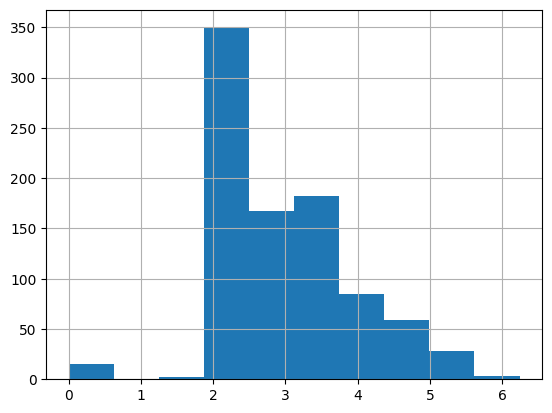

In [26]:
train_df['Log_Fare'] = np.log1p(train_df['Fare'])
train_df['Log_Fare'].hist()

In [ ]:
train_df = pd.get_dummies(train_df, columns=['Sex', 'Embarked', 'Pclass'])

added_cols = ['Sex_female',	'Sex_male',	'Embarked_C',	'Embarked_Q',	'Embarked_S',	'Pclass_1',	'Pclass_2',	'Pclass_3']

train_df[added_cols]

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,False,True,False,False,True,False,False,True
1,True,False,True,False,False,True,False,False
2,True,False,False,False,True,False,False,True
3,True,False,False,False,True,True,False,False
4,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...
886,False,True,False,False,True,False,True,False
887,True,False,False,False,True,True,False,False
888,True,False,False,False,True,False,False,True
889,False,True,True,False,False,True,False,False


In [ ]:
from torch import tensor

t_dep = tensor(train_df['Survived'])
t_dep = t_dep[:, None]

train_df['Age_Norm'] = train_df['Age'] / train_df['Age'].max()
indep_cols = ['Age_Norm', 'SibSp', 'Parch', 'Log_Fare'] + added_cols
 
t_indep = tensor(train_df[indep_cols].astype('float').values, dtype=torch.float)
v, i = t_indep.max(dim=0)
t_indep = t_indep / v

In [657]:
torch.manual_seed(42)

coeffs_len = t_indep.shape[1] 
coeffs = torch.rand(coeffs_len,1) - 0.5
coeffs

tensor([[ 0.3823],
        [ 0.4150],
        [-0.1171],
        [ 0.4593],
        [-0.1096],
        [ 0.1009],
        [-0.2434],
        [ 0.2936],
        [ 0.4408],
        [-0.3668],
        [ 0.4346],
        [ 0.0936]])

In [658]:
preds = t_indep @ coeffs
torch.sigmoid(preds)

tensor([[0.8933],
        [0.8633],
        [0.8255],
        [0.9153],
        [0.8599],
        [0.8368],
        [0.9051],
        [0.9606],
        [0.8124],
        [0.8949],
        [0.8871],
        [0.8538],
        [0.8510],
        [0.9044],
        [0.8166],
        [0.9113],
        [0.9735],
        [0.9091],
        [0.9122],
        [0.6949],
        [0.9345],
        [0.9130],
        [0.7958],
        [0.8766],
        [0.9531],
        [0.8842],
        [0.7376],
        [0.9789],
        [0.8014],
        [0.8524],
        [0.7728],
        [0.8913],
        [0.8004],
        [0.9178],
        [0.8880],
        [0.9318],
        [0.7377],
        [0.8516],
        [0.9366],
        [0.7979],
        [0.8919],
        [0.9387],
        [0.7445],
        [0.8808],
        [0.7976],
        [0.8534],
        [0.9093],
        [0.8004],
        [0.9113],
        [0.9066],
        [0.9804],
        [0.8500],
        [0.8731],
        [0.9444],
        [0.8302],
        [0

In [661]:
preds.shape, t_dep.shape
loss = torch.abs(preds - t_dep).mean()
loss

tensor(1.6677)

#### Preparing 3 models: linear, NN and Deep-NN

The model can be thought of as an interface implementation of:
 - init_coefficients()  -> returns grad-enabled represntation of model variables
 - calc_predictions(coefficients, training input)  -> applies coefficients on training input, producing an **actual** result
 - calc_loss(coefficients, training input, expected results) -> calculates predictions and measures distance to **expected** result. We're using MAE (mean abs error)
 - update_coefficients(coefficients, learning_rate)  ->  apply gradients on coefficients in propotion to LR
 - (optional) show_coefficients -> in linear we can still track what's going on, later it's getting tough

 1. Linear model implements the above as producing a vector of coeffs, and simply multiplies the input data through it. It wraps the result in Sigmoid - clamps output between (0, 1).
 1. NN-model adds in a layer in between input coefficients and output. There are 2 matrix multiplications. First is wrapped in ReLU (zero the negative values), second wrapped in Sigmoid
 1. Deep-NN-model has 2 layers in between. All but last layer is ReLU-ed, last layer is Sigmoid-ed.


In [854]:
# LINEAR

model = ''

def init_coeffs():
    global model
    model = f'Linear'
    coeffs = torch.rand(coeffs_len, 1) - 0.5
    coeffs.requires_grad_()
    return coeffs

def calc_pred(coeffs, indeps):
    return torch.sigmoid( indeps @ coeffs )

def calc_loss(coeffs, indeps, deps):
    preds = calc_pred(coeffs, indeps)
    return torch.abs( preds - deps ).mean() 

def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

def show_coeffs():
    return (dict(zip(indep_cols, coeffs.requires_grad_(False))))

In [874]:
# NEURAL NET

import torch.nn.functional as F

model = ''

def init_coeffs(hidden=10):
    global model
    layer1 = (torch.rand(coeffs_len, hidden) - 0.5) / hidden
    layer2 = torch.rand(hidden, 1) - 0.3
    const = torch.rand(1)[0]
    model = f'NN, coeffs -> hidden={hidden} -> 1'
    return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()

def calc_pred(coeffs, indeps):
    l1, l2, const = coeffs
    r1 = F.relu(indeps @ l1)
    r2 = r1@l2 + const
    return r2

def calc_loss(coeffs, indeps, deps):
    preds = calc_pred(coeffs, indeps)
    return torch.abs( preds - deps ).mean() 

def update_coeffs(coeffs, lr):
    for l in coeffs:
        l.sub_(l.grad * lr)
        l.grad.zero_()

def show_coeffs():
    l1, l2, const = coeffs
    return (dict(zip(indep_cols, l1)))

In [911]:
# DEEP NEURAL NET

import torch.nn.functional as F

model = ""


def init_coeffs():
    hiddens = [16, 8]  # <-- set this to the size of each hidden layer you want
    sizes = [coeffs_len] + hiddens + [1]

    global model
    model = f'Deep NN, model={" -> ".join(map(str,sizes))}'

    
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*5 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts


def calc_pred(coeffs, indeps):
    layers, consts = coeffs
    res = indeps
    
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i<len(layers)-1:
            res = F.relu(res)
    
    return torch.sigmoid(res)             


def calc_loss(coeffs, indeps, deps):
    preds = calc_pred(coeffs, indeps)
    return torch.abs(preds - deps).mean()


def update_coeffs(coeffs, lr):
    layers, consts = coeffs
    for l in layers+consts:
        l.sub_(l.grad * lr)
        l.grad.zero_()


def show_coeffs():
    pass

In [781]:
# METRICS

def acc(coeffs, eval_indep, eval_dep):
    eval_pred = calc_pred(coeffs, eval_indep)
    return (eval_dep.bool() == (eval_pred>0.5)).float().mean()

In [663]:
from fastai.data.transforms import RandomSplitter 

train, eval = RandomSplitter(seed=42)(train_df)

train_indep, eval_indep = t_indep[train], t_indep[eval]
train_dep, eval_dep = t_dep[train], t_dep[eval]


In [801]:

def epoch(coeffs, lr):
    loss = calc_loss(coeffs, train_indep, train_dep)
    loss.backward()
    with torch.no_grad(): 
        update_coeffs(coeffs, lr)
    return loss
    

def train_model(epochs=30, lr=0.1):
    torch.manual_seed(442)
    params = init_coeffs()
    
    losses = []
    for i in range(epochs):
        loss = epoch(params, lr)
        losses.append(loss.item())
    
    pd.Series(losses).plot.line(title=f'Loss function, model={model}, epochs={epochs}, LR={lr}')

    print(f'Final loss = {loss: .3f}')
        
    return params

Final loss =  0.190
Accuracy = 0.83


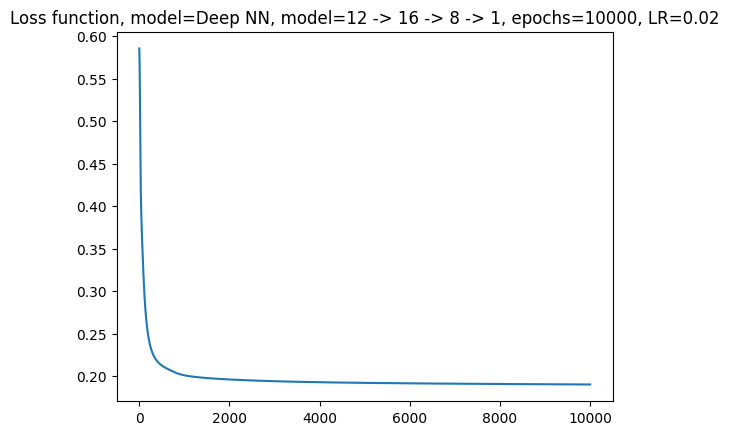

In [913]:
coeffs = train_model(epochs=10000, lr=0.02)

accuracy = acc(coeffs, eval_indep, eval_dep)
print(f'Accuracy = {accuracy :.2f}')


In [833]:
show_coeffs()

## Submission to Kaggle

In [884]:
tst_df = pd.read_csv(path/'test.csv')

tst_df = tst_df.fillna(tst_df.mode())

tst_df['Log_Fare'] = np.log1p(tst_df['Fare'])
tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"])

tst_df['Age_Norm'] = tst_df['Age'] / tst_df['Age'].max()

tst_indep = tensor(tst_df[indep_cols].astype('float').values, dtype=torch.float)

v, i = t_indep.max(dim=0)
t_indep = t_indep / v

In [ ]:
res = calc_pred(coeffs, tst_indep)
tst_df['Survived'] = (res>0.5).int()

sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

sub_df["Survived"].value_counts()


Survived
0    323
1     95
Name: count, dtype: int64

In [ ]:
from datetime import datetime

a = kaggle.api.competition_submit_cli('sub.csv', message=f'Submission from code on {datetime.now()}', competition=competition)



100%|██████████| 3.18k/3.18k [00:00<00:00, 6.89kB/s]


'Successfully submitted to Titanic - Machine Learning from Disaster'